In [1]:
import glob
import copy

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt

import astropy.units as u

import emcee
import corner

from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from helpers import plot_data_model, get_fit_params, get_full_params

### Specify the location of the model and observed data

In [2]:
data_file_path = "/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/data/faintwds/"
model_file_path = "/home/kgordon/Python/extstar_data/"

### Define the star names and related info

In [3]:
starnames = ["wdfs0122_30",
             "wdfs0248_33",
             "wdfs0458_56",
             "wdfs0639_57",
             "wdfs0956_38",
             "wdfs1055_36",
             "wdfs1110_17",
             "wdfs1206_27",
             "wdfs1214_45",
             "wdfs1302_10",
             "wdfs1434_28",
             "wdfs1535_77",
             "wdfs1557_55",
             "wdfs1814_78",
             "wdfs1837_70",
             "wdfs1930_52",
             "wdfs2317_29",
             "wdfs2351_37",
            ]

starnames_wopt = ["wdfs1514_00",
                 ]

# info from Axelrod et al. 2023
atmoinfo = {"wdfs0122_30": [(33900., 100.0), (7.77, 0.05)], 
            "wdfs0248_33": [(33100., 100.0), (7.10, 0.05)],
            "wdfs0458_56": [(30100., 100.0), (7.79, 0.05)],
            "wdfs0639_57": [(54700., 100.0), (7.89, 0.05)],
            "wdfs0956_38": [(19200., 100.0), (7.88, 0.05)],
            "wdfs1055_36": [(29500., 100.0), (7.93, 0.05)],
            "wdfs1110_17": [(46400., 100.0), (8.00, 0.05)],
            "wdfs1206_27": [(53600., 100.0), (7.89, 0.05)],
            "wdfs1214_45": [(34200., 100.0), (7.85, 0.05)],
            "wdfs1302_10": [(41600., 100.0), (7.93, 0.05)],
            "wdfs1434_28": [(20300., 100.0), (7.82, 0.05)],
            "wdfs1514_00": [(28500., 10.0), (7.90, 0.01)],
            "wdfs1514_00_nophot": [(28500., 10.0), (7.90, 0.01)],
            "wdfs1514_00_nospec": [(28500., 10.0), (7.90, 0.01)],
            "wdfs1514_00_nooverlap": [(28500., 1.0), (7.90, 0.001)],
            "wdfs1535_77": [(50500., 100.0), (9.10, 0.05)],
            "wdfs1557_55": [(57800., 100.0), (7.55, 0.05)],
            "wdfs1814_78": [(31000., 100.0), (7.80, 0.05)],
            "wdfs1837_70": [(19200., 100.0), (7.87, 0.05)],
            "wdfs1930_52": [(36300., 100.0), (7.67, 0.05)],
            "wdfs2317_29": [(23100., 100.0), (7.85, 0.05)],
            "wdfs2351_37": [(41200., 100.0), (7.70, 0.05)], 
           }

# Faint WDs for JWST/Roman/HST WDFS0122-30, WDFS0458-56, WDFS1302+10, WDFS1557+55, WDFS2317-29

### Information that is the same for all the stars

In [4]:
# parameter names
pnames = ["logT","logg", "logZ", "Av","Rv","C2","B3","C4","x0","gamma","HI_gal","HI_mw"]
# logZ and HI_mw not fit as sources in MW so HI_gal = HI_MW
pnames_fit = ["logT","logg", "Av","Rv","C2","B3","C4","x0","gamma","logHI"]

# initial starting position
init_params = [4.5, 7.5, 0.0, 0.5, 3.0, 0.73, 3.60, 0.4, 4.59, 0.89, 20.5, 17.0]

# add Gaussian priors based on prior knowledge
ppriors = {}
# based on VCG04 and FM07 MW samples
ppriors["Rv"] = (3.0, 0.4)
ppriors["C2"] = (0.73, 0.25)
#ppriors["C3"] = (2.85, 0.7)
ppriors["B3"] = (3.6, 0.6)
ppriors["C4"] = (0.4, 0.2)
ppriors["x0"] = (4.59, 0.02)
ppriors["gamma"] = (0.89, 0.08)

relband = "WFC3_F625W"

# cropping info for weights
#  bad regions are defined as those were we know the models do not work
#  or the data is bad
ex_regions = [
    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
    [8.7, 10.0],  # bad data from STIS
    [3.55, 3.6],
    [3.80, 3.90],
    [4.15, 4.3],
    [6.4, 6.6],
    [7.1, 7.3],
    [7.45, 7.55],
    [7.65, 7.75],
    [7.9, 7.95],
    [8.05, 8.1],
] / u.micron

velocity = 0.0   # assumption

## Code to fit a single star

In [5]:
def fit_star_sed(starname, atmoinfo, velocity,
                 init_params, pnames, ppriors,
                 modinit, modinfo, plimits):
    
    print("")
    print(f"working on {starname}")
    fstarname = f"{starname}.dat"
    # velocity = 0.0   # assumption

    # Teff, logg, from Narayan et al. 2019
    tinfo = atmoinfo[starname][0]
    ginfo = atmoinfo[starname][1]
    teff = tinfo[0]
    teff_unc = tinfo[1]
    logt = np.log10(teff)
    logt_unc = 0.5 * (np.log10(teff + teff_unc) - np.log10(teff - teff_unc))
    logg = ginfo[0]
    logg_unc = ginfo[1]

    params = copy.copy(init_params)
    params[0] = logt
    params[1] = logg
    
    # ppriors["logT"] = (logt, logt_unc)
    # ppriors["logg"] = (logg, logg_unc)

    # set uncertainties to really force logt and logg to not vary much
    ppriors["logT"] = (logt, 10.0)
    ppriors["logg"] = (logg, 0.001)
    
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{data_file_path}")
    if "BAND" in reddened_star.data.keys():
        band_names = reddened_star.data["BAND"].get_band_names()
    else:
        band_names = []
    data_names = list(reddened_star.data.keys())

    # define the weights for the fitting
    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
        
        # add a floor to the spectroscopic and band uncertainties
        #if cspec != "BAND":
        #    new_uncs = np.sqrt(np.square(reddened_star.data[cspec].uncs[gvals].value)
        #                       + (np.square(0.01 * reddened_star.data[cspec].fluxes[gvals].value)))
        #else:
        #if cspec == "BAND":
        #    new_uncs = np.sqrt(np.square(reddened_star.data[cspec].uncs[gvals].value)
        #                       + np.square((0.01 * reddened_star.data[cspec].fluxes[gvals].value)))
        #else:

        new_uncs = reddened_star.data[cspec].uncs[gvals].value
        weights[cspec][gvals] = 1.0 / new_uncs
        
        if cspec != "BAND":
            weights[cspec][gvals] *= 2.0
        
        #if cspec in ["STIS", "STIS_Opt"]:
        #    extra_weight_waves = np.array([0.15, 0.2175, 0.30, 0.6]) * u.micron
        #    for cwave in extra_weight_waves:
        #        bvals = np.absolute(reddened_star.data[cspec].waves - cwave) < cwave * 0.05
        #        weights[cspec][bvals] *= 100.0

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

        # add extra weight for the bump region
        # gvals = np.logical_and(x >= 4.4/u.micron, x <= 5./u.micron)
        weights[cspec][gvals] *= 3.0

    # get the stellar atmosphere models
    if not modinit:
        modinit = True
        tlusty_models_fullpath = glob.glob(f"{model_file_path}/Models/wd_hubeny*.dat")
        # tlusty_models_fullpath = glob.glob(f"{model_file_path}/Models/wd_hubeny_t950g950n*.dat")
        tlusty_models = [
            tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
        ]

        # get the models with just the reddened star band data and spectra
        modinfo = ModelData(
            tlusty_models,
            path=f"{model_file_path}/Models/",
            band_names=band_names,
            spectra_names=data_names,
        )
    
        # not all these parameters are being fit
        #   not fitting for met, log(HI) MW foreground
        plimits = [
                [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
                [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
                [0.0, 0.0], # met
                [0.0, 1.0],   # Av
                [2.31, 5.59],   # Rv
                [-0.1, 5.0],  # C2
                # [-1.0, 6.0],   # C3
                [-1.0, 8.0],   # B3
                [-0.5, 1.5],   # C4
                [4.5, 4.9],   # xo
                [0.4, 1.7],   # gamma
                [18.0, 24.0], # log(HI) internal to galaxy
                [17.0, 22.0], # log(HI) MW foreground
            ]
    
    # package the fit info needed.  FitInfo class defines the likelihood functions as well.
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    
    print("initial parameters")
    print(params)
    # check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
    fitinfo.check_param_limits(params)
    print("all sound be negative, no NaNs or Infs")
    print("starting lnlike:", fitinfo.lnlike(params, reddened_star, modinfo))
    print("starting lnprior:", fitinfo.lnprior(params))
    print("starting lnprob:", fitinfo.lnprob(params, reddened_star, modinfo, fitinfo)) 
    
    # simple function to turn the log(likelihood) into the chisqr
    #  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
    def nll(params, *args):
        full_params = get_full_params(params)
        return -fitinfo.lnprob(full_params, *args)

    init_fit_params = get_fit_params(params)

    # run the fit
    result = op.minimize(
        nll, init_fit_params, method="Nelder-Mead", options={"maxiter": 10000}, 
        args=(reddened_star, modinfo, fitinfo)
    )

    # check the fit output
    print(result["message"])
    
    # print results
    fit_params = get_full_params(result["x"])
    params_best = fit_params
    fit_params_fit = get_fit_params(fit_params)

    # print the best fit
    print("best fit parameters (ignore logZ, HI_mw)")
    for k, val in enumerate(params_best):
        print(f"{val} # {pnames[k]}")
        
    # plot optimizer/minimizer best fit

    plot_data_model(reddened_star, weights, modinfo, fit_params_fit, pnames_fit, starname, velocity)
    plt.savefig(f"{starname}_best_fit_from_optimizer.png")
    
    # do the MCMC sampling to get the uncertainties
    if mcmc_nsteps > 0:
        p0 = get_fit_params(fit_params)
        ndim = len(p0)

        def lnprob_mcmc(params, *args):
            full_params = get_full_params(params)
            return fitinfo.lnprob(full_params, *args)

        nwalkers = 2 * ndim

        # setting up the walkers to start "near" the inital guess
        p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

        # setup the sampler
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, lnprob_mcmc, args=(reddened_star, modinfo, fitinfo)
        )

        # do the full sampling
        pos, prob, state = sampler.run_mcmc(p, mcmc_nsteps, progress=True)
        
        # create the samples variable for later use
        flat_samples = sampler.get_chain(discard=int(0.1*mcmc_nsteps), flat=True)

        # get the best fit values
        params_best = get_best_fit_params(sampler)

        def get_percentile_params(samples):
            """
            Determine the 50p plus/minus 33p vlaues
            """

            per_params = map(
                lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                zip(*np.percentile(samples, [16, 50, 84], axis=0)),
            )

            return per_params

        # get the 16, 50, and 84 percentiles
        params_per = get_percentile_params(flat_samples)

        # save the best fit and p50 +/- uncs values to a file
        # save as a single row table to provide a uniform format
        #f = open(out_basename + "_fit_params.dat", "w")
        #f.write("# best fit, p50, +unc, -unc\n")
        n_params = len(params_best)
        params_p50 = np.zeros(n_params)
        params_unc = np.zeros(n_params)
        print("best p50 -munc +unc # paramname")
        for k, val in enumerate(params_per):
            params_p50[k] = val[0]
            params_unc[k] = 0.5 * (val[1] + val[2])
            print(f"{params_best[k]:.3f} {val[0]:.3f} {val[1]:.3f} {val[2]:.3f} # {pnames_fit[k]}")
            
        fit_params = get_full_params(params_best)
        plot_data_model(reddened_star, weights, modinfo, params_p50, pnames_fit, starname, velocity, 
                        params_unc=params_unc)
        plt.savefig(f"{starname}_best_fit_from_mcmc.png")
        
        # chain plot
        nparam = len(params_best)
        fig, axes = plt.subplots(nparam, figsize=(10, 15), sharex=True)
        samples = sampler.get_chain()
        labels = pnames_fit
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number")
        plt.savefig(f"{starname}_chain_from_mcmc.png")
        
        # corner plot
        fig = corner.corner(flat_samples, labels=labels)
        plt.savefig(f"{starname}_corner_from_mcmc.png")
        
    return (modinit, modinfo, plimits)

### Variable to control MCMC sampling

In [6]:
# mcmc_nsteps = 5000   # set to zero to skip MCMC fitting
mcmc_nsteps = 0

## Fit all stars w/ UV + Optical spectra

In [7]:
modinit1 = False # set to True if have already run next cell at least once
if not modinit1:
    plimits1 = None
    modinfo1 = None


working on wdfs1514_00
initial parameters
[np.float64(4.45484486000851), 7.9, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -244782916.07243598
starting lnprior: 0.0
starting lnprob: -244782916.07243598
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.513470813940245 # logT
8.227439454694288 # logg
0.0 # logZ
0.1121328663426803 # Av
2.3213949775091827 # Rv
0.7727388283129182 # C2
5.073166840183111 # B3
0.4618244374180114 # C4
4.722040876216962 # x0
0.987993971519092 # gamma
20.74642692212347 # HI_gal
17.0 # HI_mw


/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec


--- 578.1676235198975 seconds ---


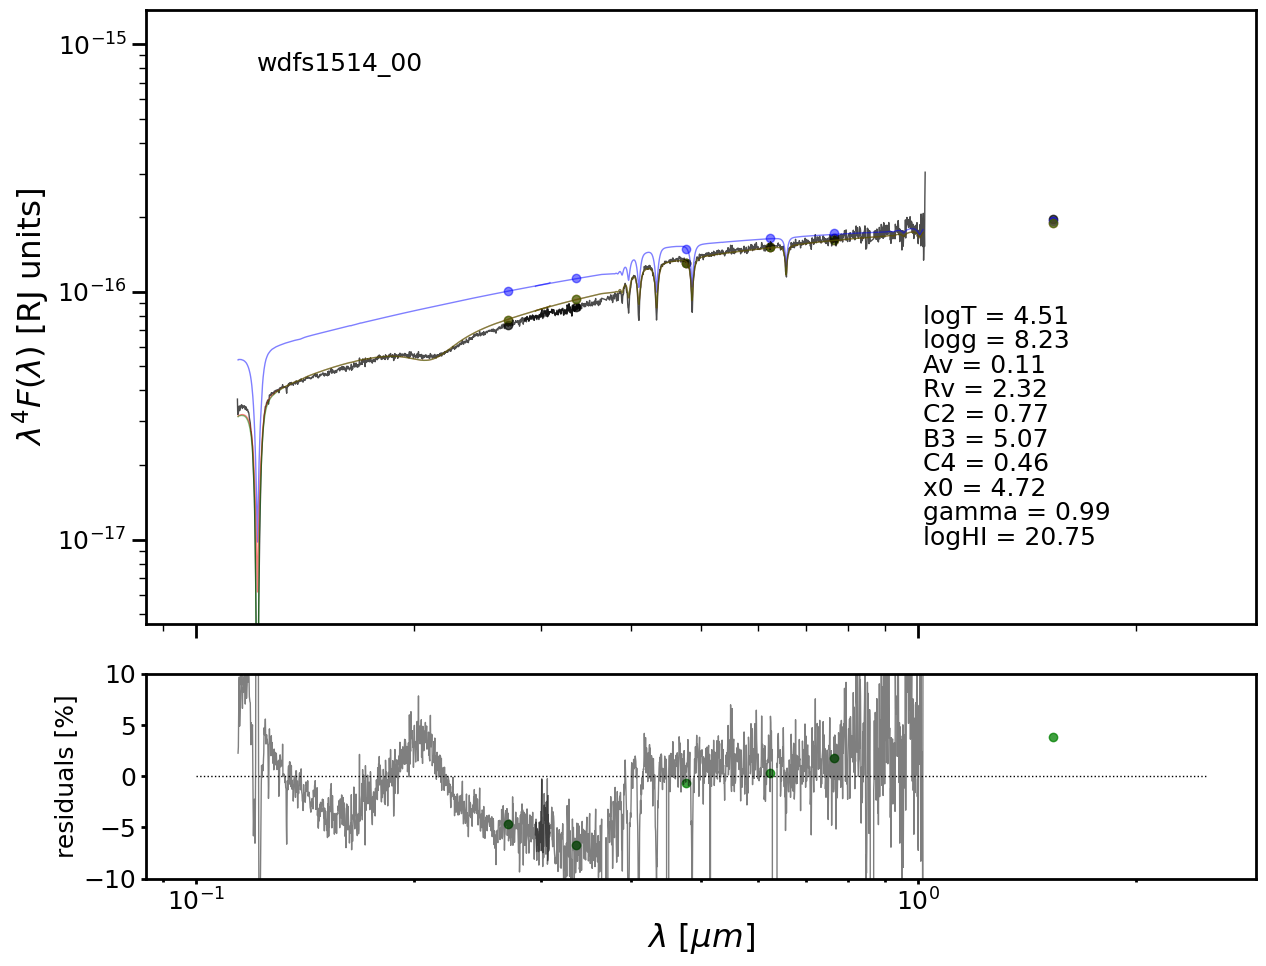

In [8]:
import time
start_time = time.time()

for starname in starnames_wopt:
    modinit1, modinfo1, plimits1 = fit_star_sed(starname, atmoinfo, velocity,
                                                init_params, pnames, ppriors,
                                                modinit1, modinfo1, plimits1)
print("--- %s seconds ---" % (time.time() - start_time))

## Fit all the stars w/ only UV spectra

In [9]:
modinit = False # set to True if have already run next cell at least once
if not modinit:
    plimits = None
    modinfo = None


working on wdfs0122_30
initial parameters
[np.float64(4.5301996982030825), 7.77, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -4360519.891825712
starting lnprior: 0.0
starting lnprob: -4360519.891825712
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.56516687986298 # logT
7.770584465560857 # logg
0.0 # logZ
0.144248183150863 # Av
5.5827881119699025 # Rv
0.8467491869849699 # C2
2.7643568658407274 # B3
0.38251924618360567 # C4
4.8180418972578885 # x0
0.4004268649908708 # gamma
18.000002037231138 # HI_gal
17.0 # HI_mw

working on wdfs0248_33
initial parameters
[np.float64(4.519827993775719), 7.1, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -1040162.4568225624
starting lnprior: 0.0
starting lnprob: -1040162.4568225624
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.653025672476861 # logT
7.096

/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs0458_56
initial parameters
[np.float64(4.478566495593843), 7.79, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -11679294.546292027
starting lnprior: 0.0
starting lnprob: -11679294.546292027
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.586281384457034 # logT
7.798617925500412 # logg
0.0 # logZ
0.1757932007366666 # Av
5.5899999999597 # Rv
0.5471770915672065 # C2
2.951371010139844 # B3
0.23755683517398313 # C4
4.897397309729854 # x0
0.994017687387733 # gamma
21.008466575910095 # HI_gal
17.0 # HI_mw


/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs0639_57
initial parameters
[np.float64(4.737987326333431), 7.89, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -3963110.296240138
starting lnprior: 0.0
starting lnprob: -3963110.296240138
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.659045542792398 # logT
7.890778500113154 # logg
0.0 # logZ
0.16463458230044617 # Av
5.176463013964686 # Rv
0.5466261301313488 # C2
4.2764615354470426 # B3
0.4741957943511458 # C4
4.639836905545961 # x0
0.6964370811773202 # gamma
18.00007973658191 # HI_gal
17.0 # HI_mw

working on wdfs0956_38
initial parameters
[np.float64(4.283301228703549), 7.88, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -7150668.167971248
starting lnprior: 0.0
starting lnprob: -7150668.167971248
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.410756764349189 # logT
7.874999

/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs1055_36
initial parameters
[np.float64(4.469822015978163), 7.93, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -4821401.958333632
starting lnprior: 0.0
starting lnprob: -4821401.958333632
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.448813545648251 # logT
7.9359150353793595 # logg
0.0 # logZ
0.11119311609929128 # Av
4.801913867333402 # Rv
1.4205739148779424 # C2
4.013628433893286 # B3
0.3315842782328411 # C4
4.667948600888696 # x0
0.7176917497864628 # gamma
20.331253112067806 # HI_gal
17.0 # HI_mw

working on wdfs1110_17
initial parameters
[np.float64(4.666517980554881), 8.0, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -3872524.3112604786
starting lnprior: 0.0
starting lnprob: -3872524.3112604786
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.812913355798378 # logT
7.9999

/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs1535_77
initial parameters
[np.float64(4.703291378118661), 9.1, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -27388447.91089607
starting lnprior: 0.0
starting lnprob: -27388447.91089607
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.738005133622153 # logT
9.096863693981586 # logg
0.0 # logZ
0.08187269324851824 # Av
5.585415943589464 # Rv
0.8120157955526801 # C2
1.896164354332983 # B3
0.5857960445486717 # C4
4.698967571106529 # x0
0.40000000018117343 # gamma
19.8674049385426 # HI_gal
17.0 # HI_mw

working on wdfs1557_55
initial parameters
[np.float64(4.7619278384205295), 7.55, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -11343697.976479871
starting lnprior: 0.0
starting lnprob: -11343697.976479871
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.722832855246619 # logT
7.53957

/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs1930_52
initial parameters
[np.float64(4.559906625036112), 7.67, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -7377360.1904106755
starting lnprior: 0.0
starting lnprob: -7377360.1904106755
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.975141214897496 # logT
7.668995216571161 # logg
0.0 # logZ
0.3918710183153906 # Av
5.414382084251382 # Rv
1.3325544100125981 # C2
2.6063537321322454 # B3
-0.05299609643002423 # C4
4.679563686791383 # x0
0.8540404096359924 # gamma
21.070125875150822 # HI_gal
17.0 # HI_mw


/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs2317_29
initial parameters
[np.float64(4.363611979892144), 7.85, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -11798837.876493463
starting lnprior: 0.0
starting lnprob: -11798837.876493463
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.428666248391668 # logT
7.851339094281004 # logg
0.0 # logZ
0.3265481535387197 # Av
5.589999953639525 # Rv
0.7367286133714177 # C2
1.2676971932067227 # B3
0.3090135408449819 # C4
4.823250309754876 # x0
0.9904560863236735 # gamma
21.537538330758423 # HI_gal
17.0 # HI_mw


/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec



working on wdfs2351_37
initial parameters
[np.float64(4.6148972160331345), 7.7, 0.0, 0.5, 3.0, 0.73, 3.6, 0.4, 4.59, 0.89, 20.5, 17.0]
all sound be negative, no NaNs or Infs
starting lnlike: -1146376.9183516365
starting lnprior: 0.0
starting lnprob: -1146376.9183516365
Optimization terminated successfully.
best fit parameters (ignore logZ, HI_mw)
4.977723559989425 # logT
7.704669829394492 # logg
0.0 # logZ
0.4336389809394248 # Av
2.9802240886019167 # Rv
0.8277243014962614 # C2
3.457709453579697 # B3
0.12270916564724146 # C4
4.606635871294792 # x0
0.8374299984029681 # gamma
21.185502754867432 # HI_gal
17.0 # HI_mw


/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/notebooks/helpers.py:110: RuntimeWarning: divide by zero encountered in divide
  diff = 100.0 * (reddened_star.data[cspec].fluxes.value - modspec) / modspec


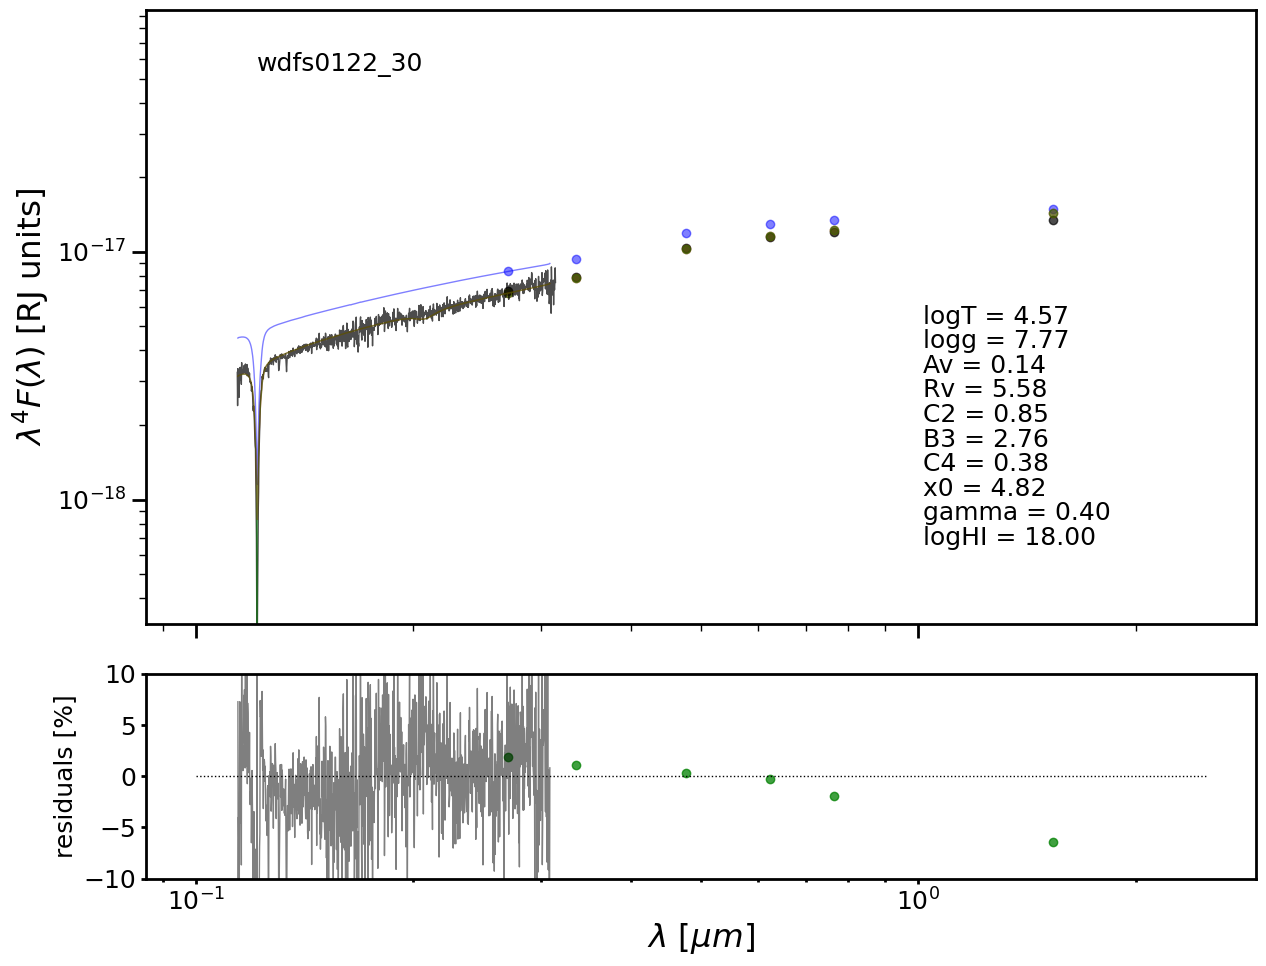

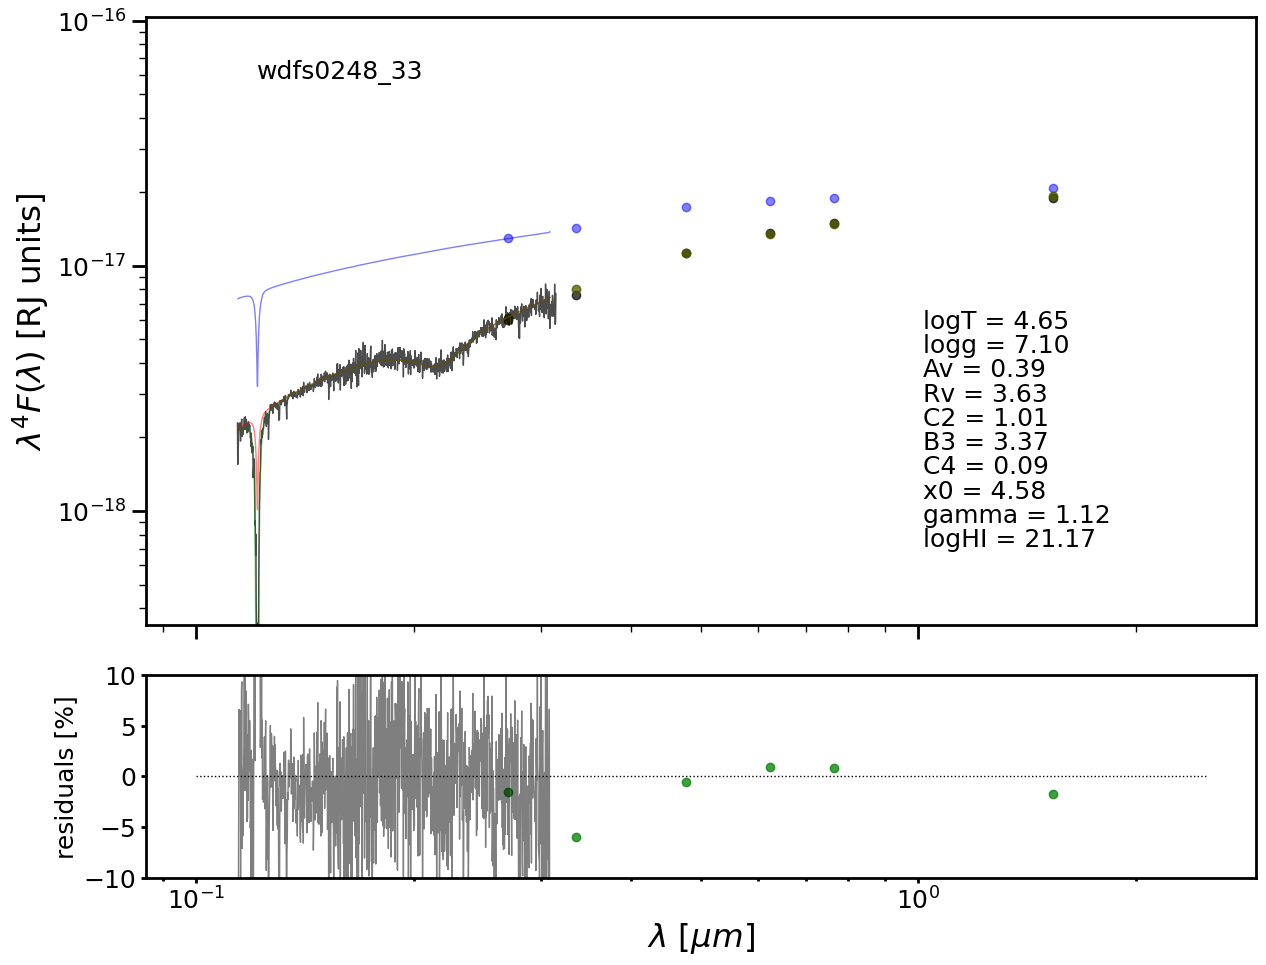

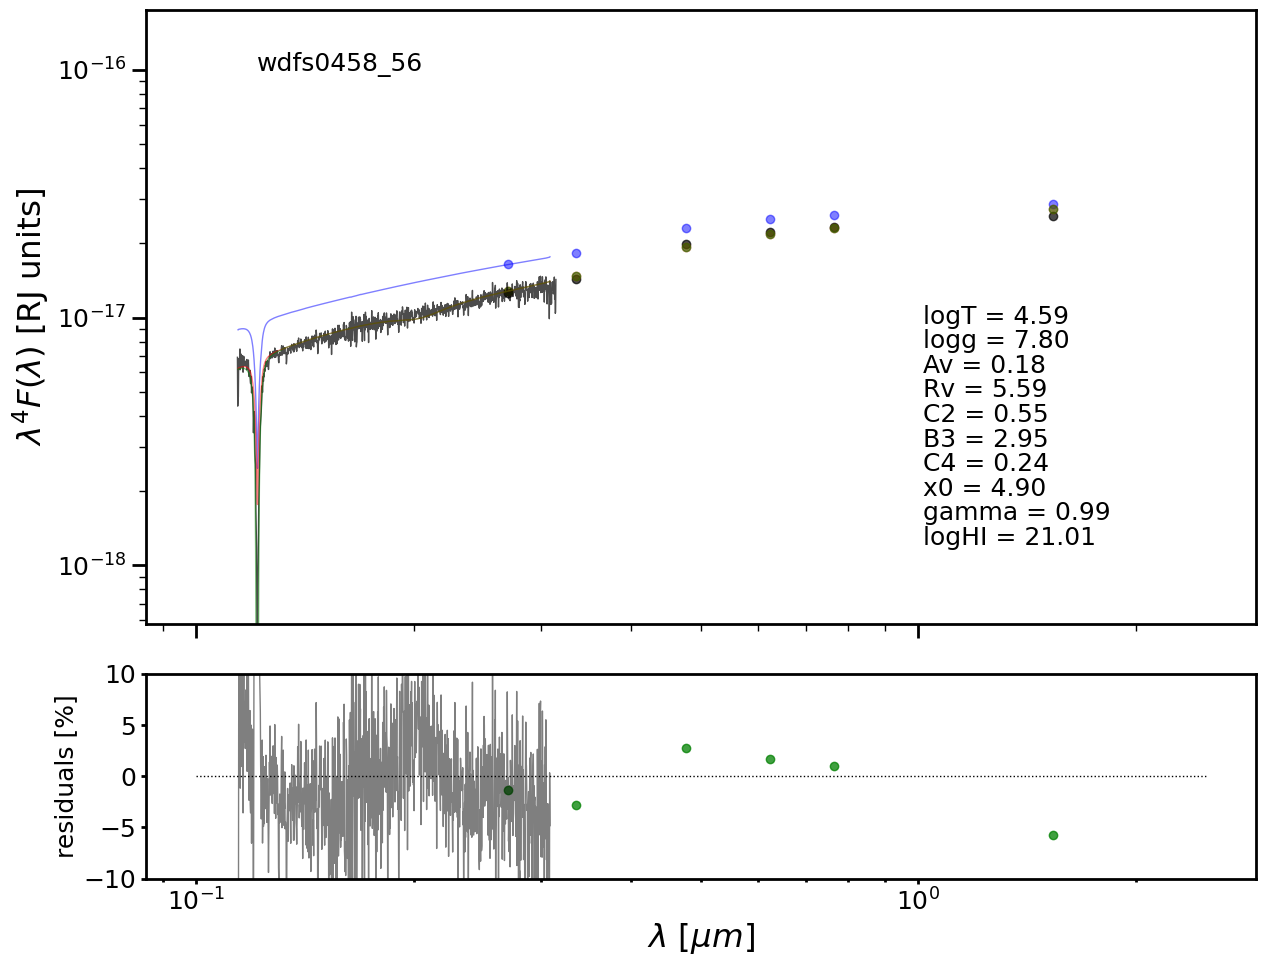

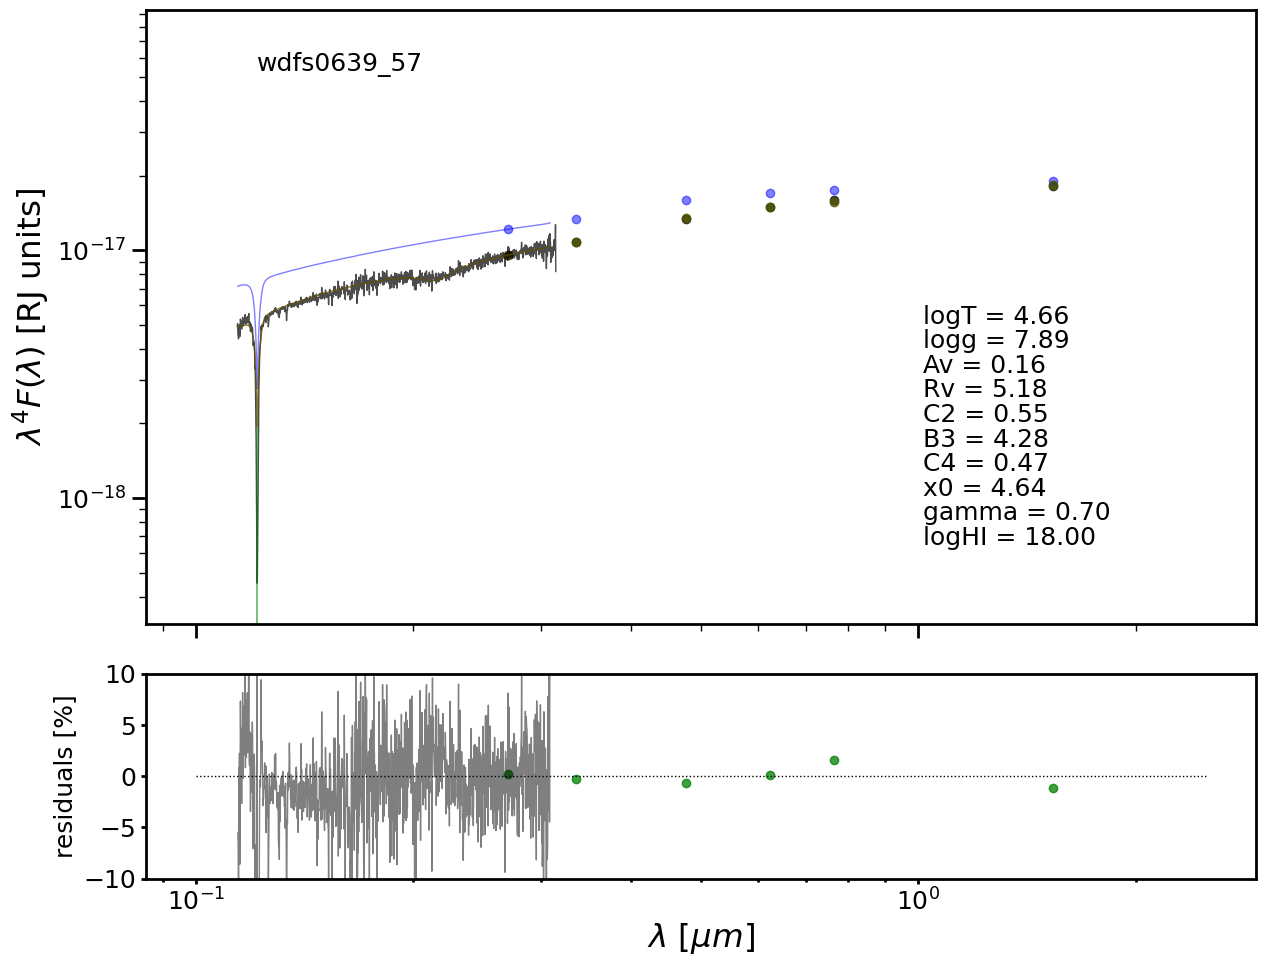

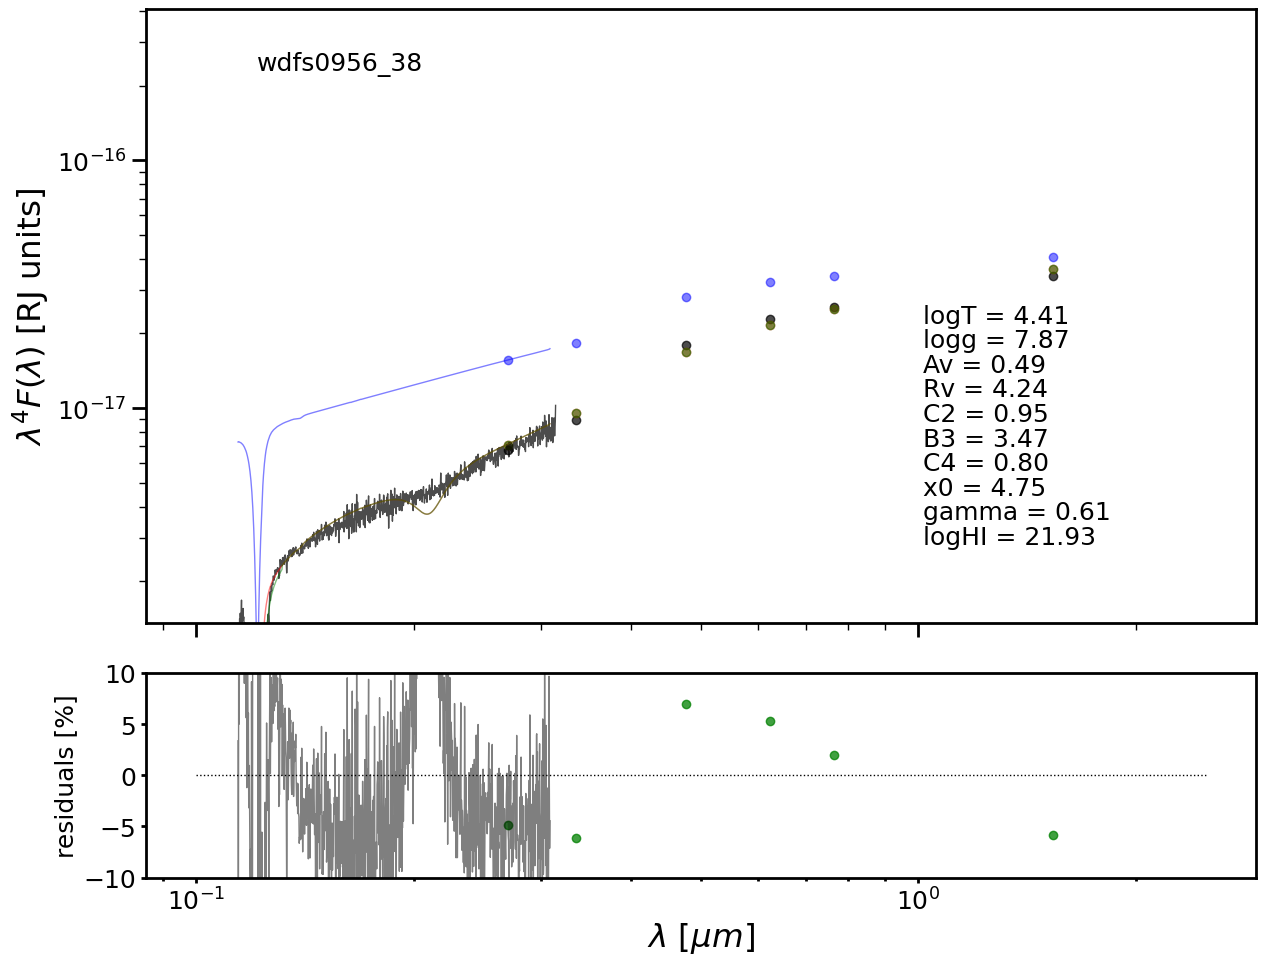

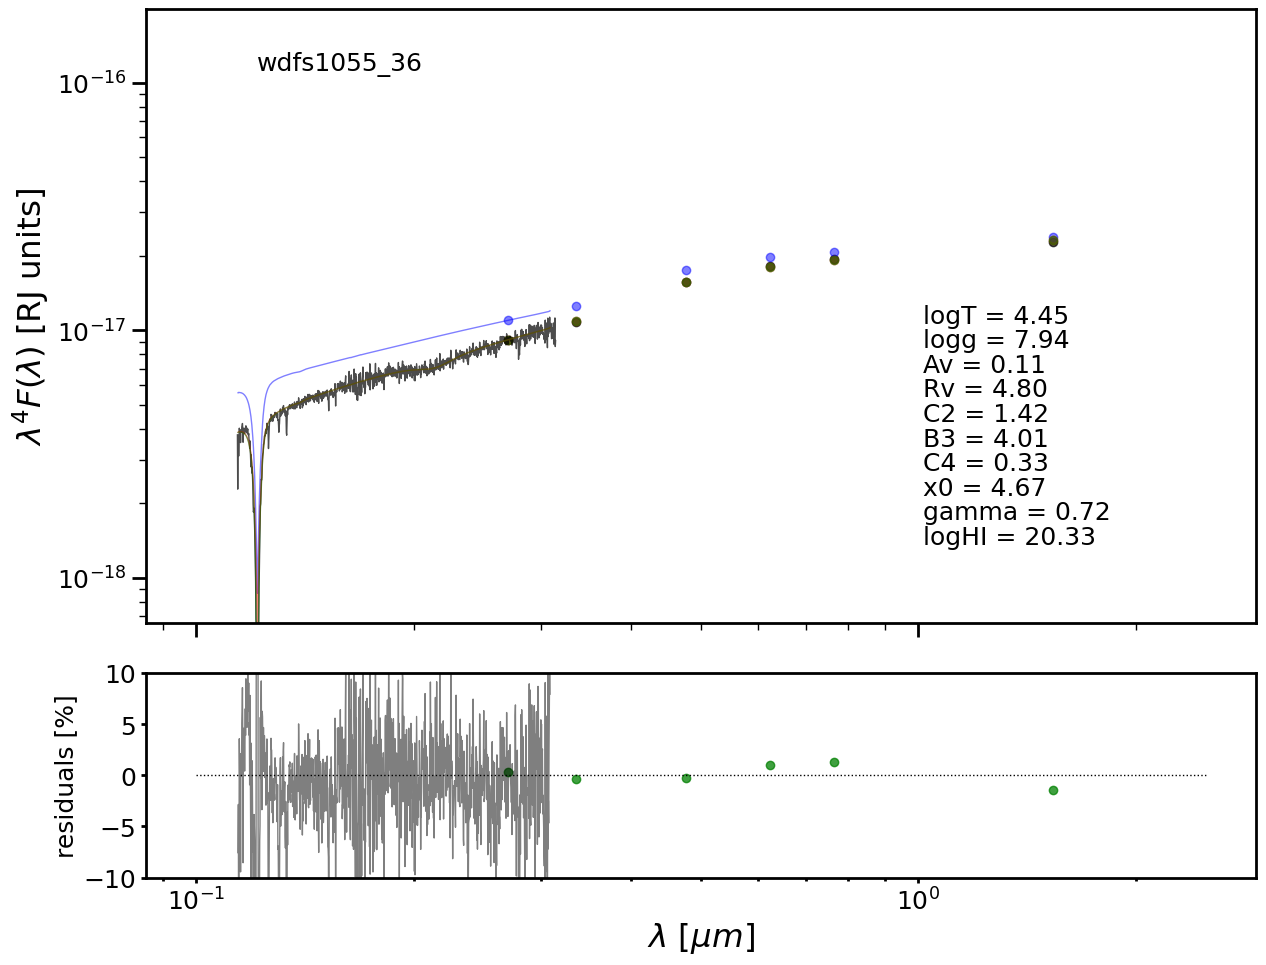

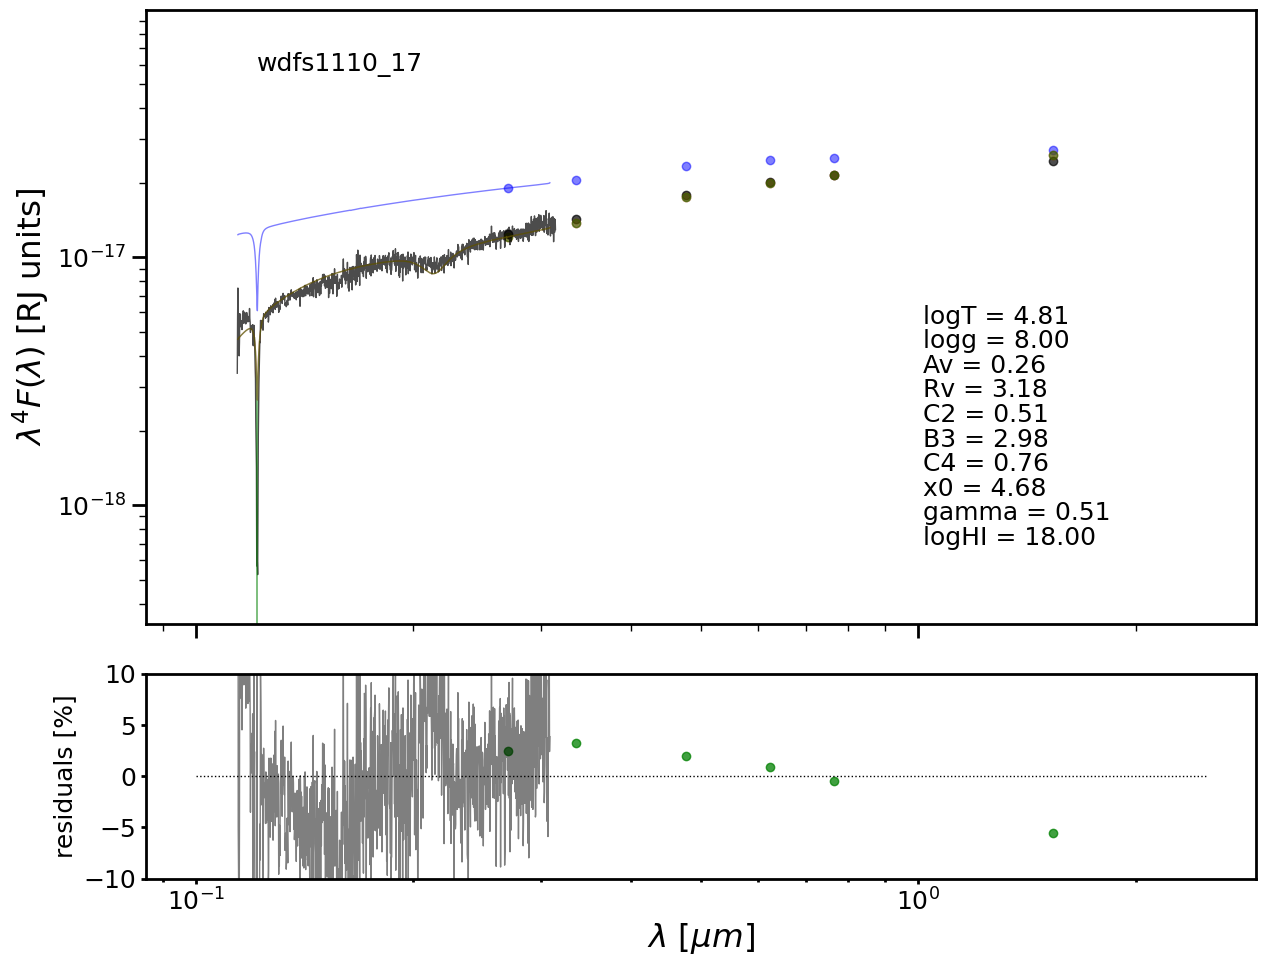

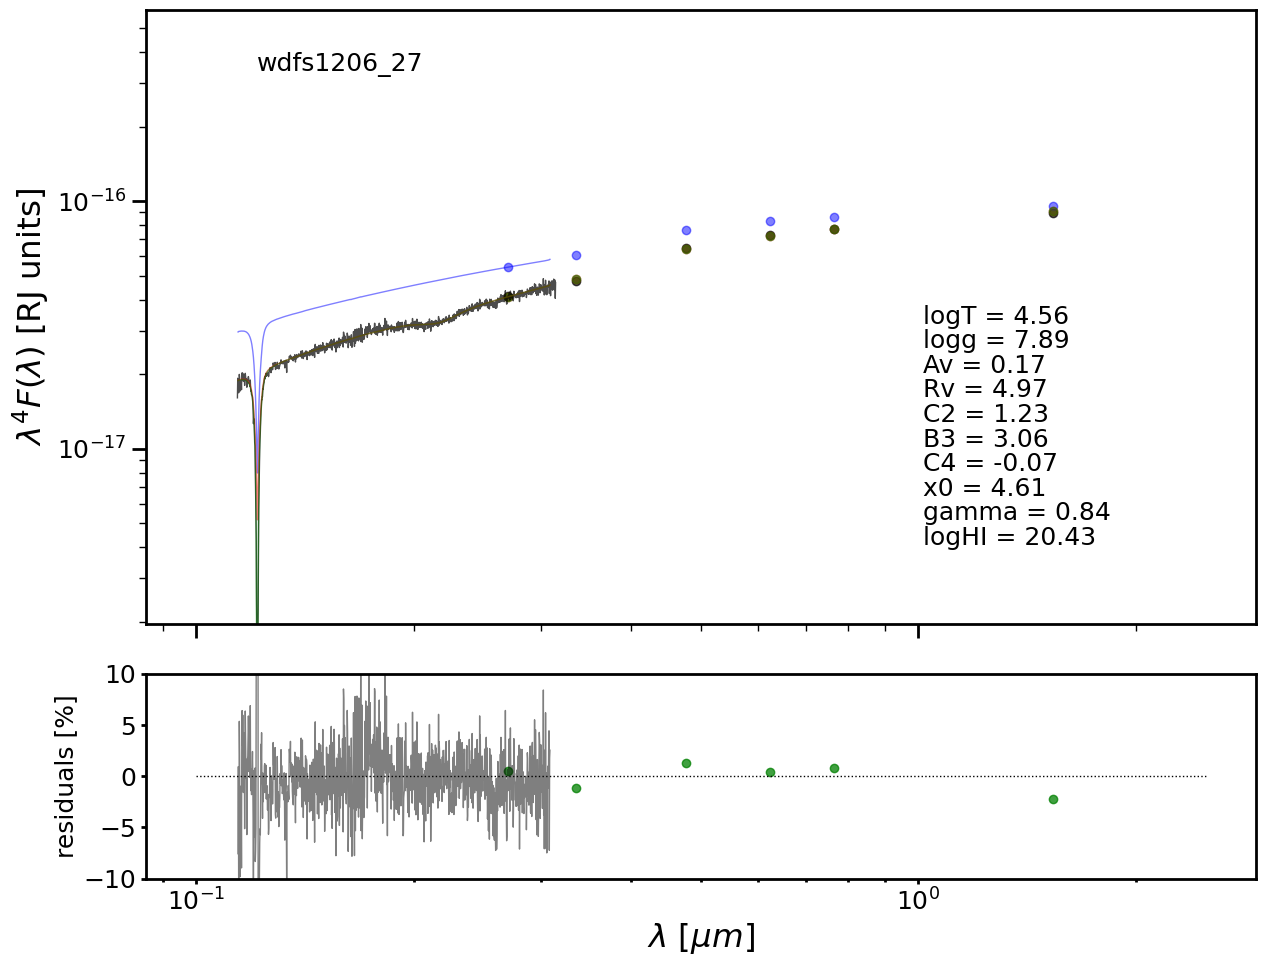

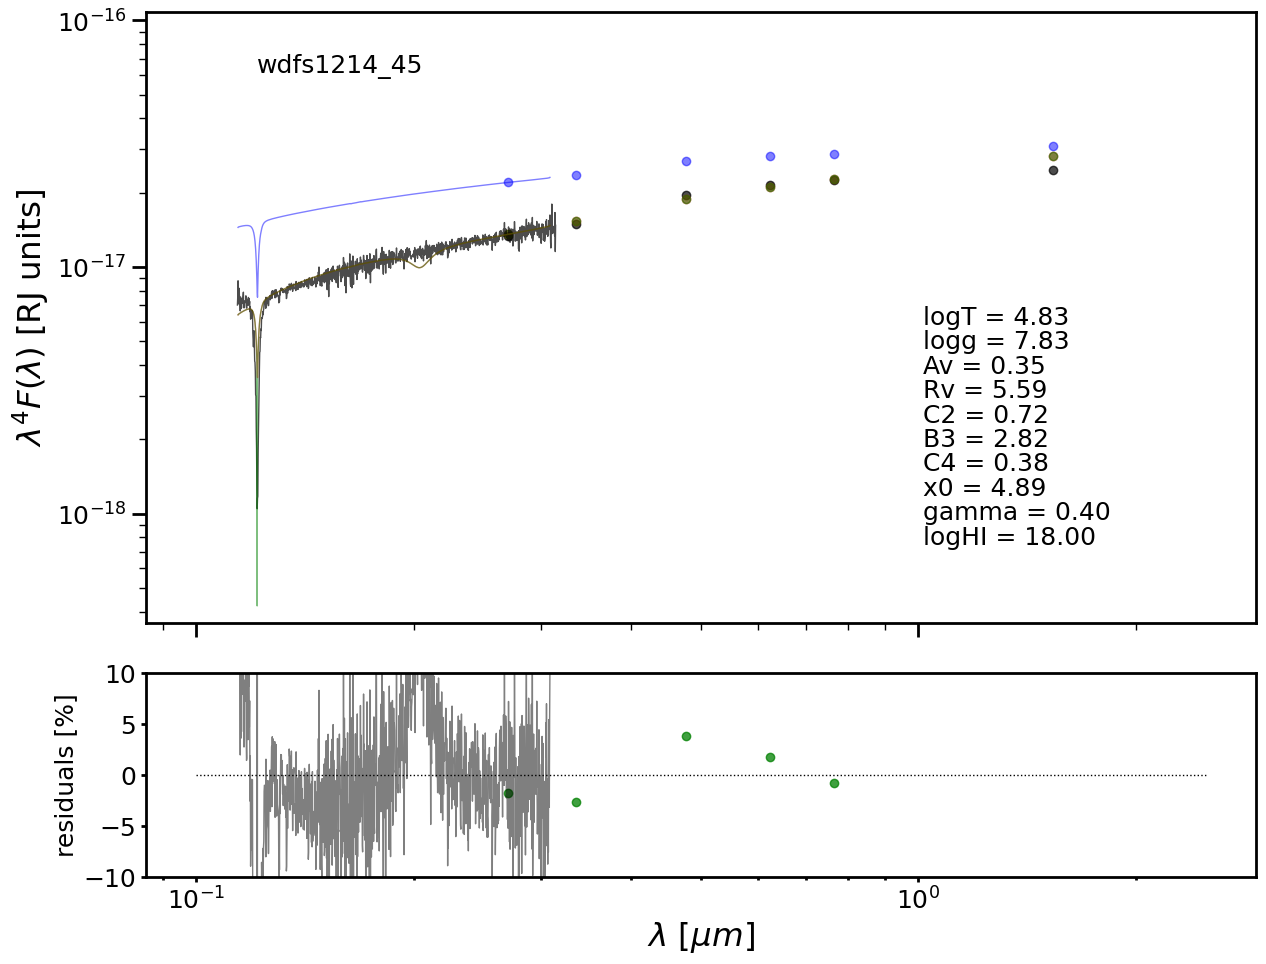

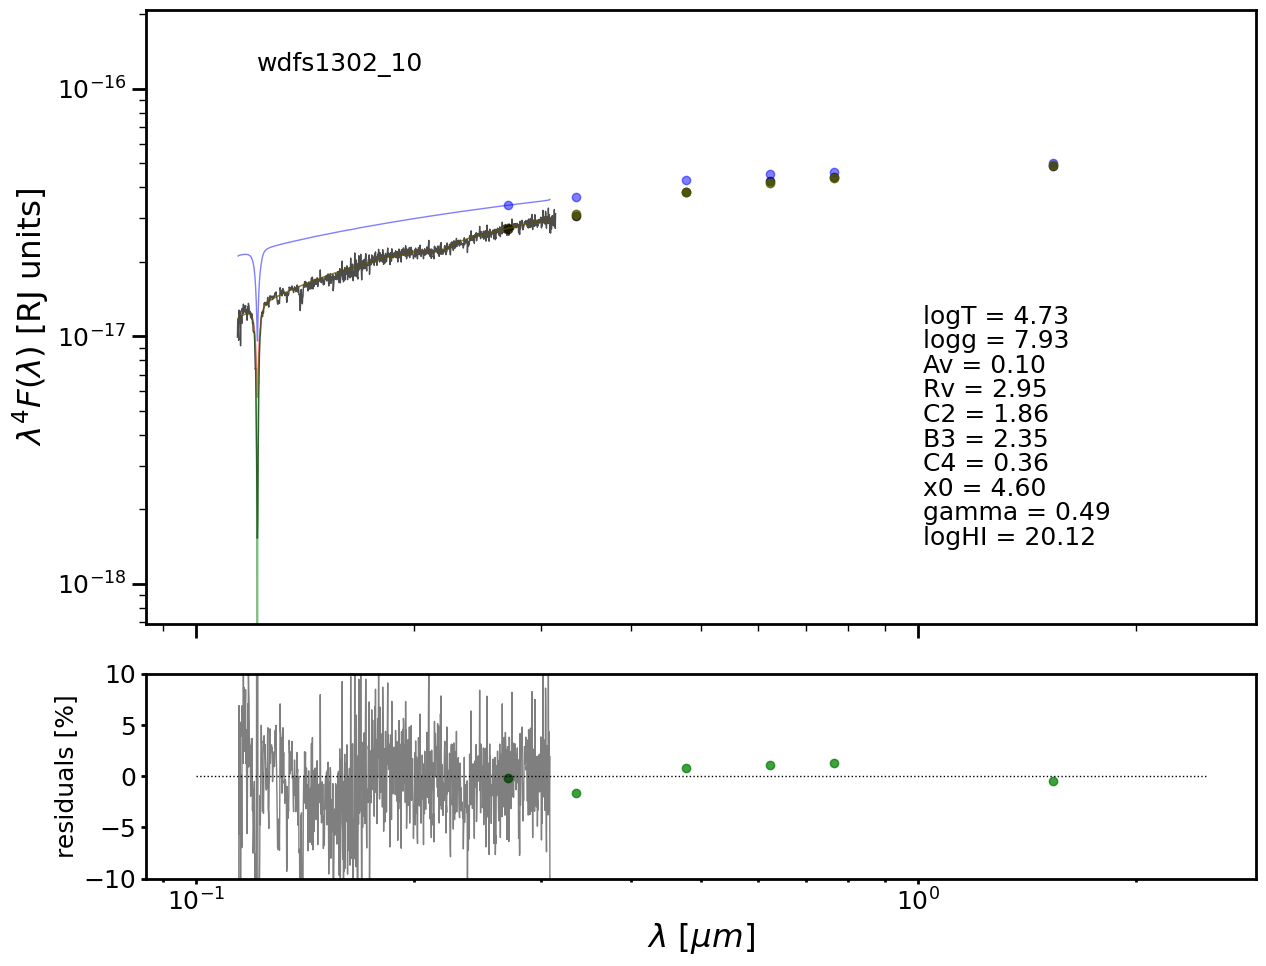

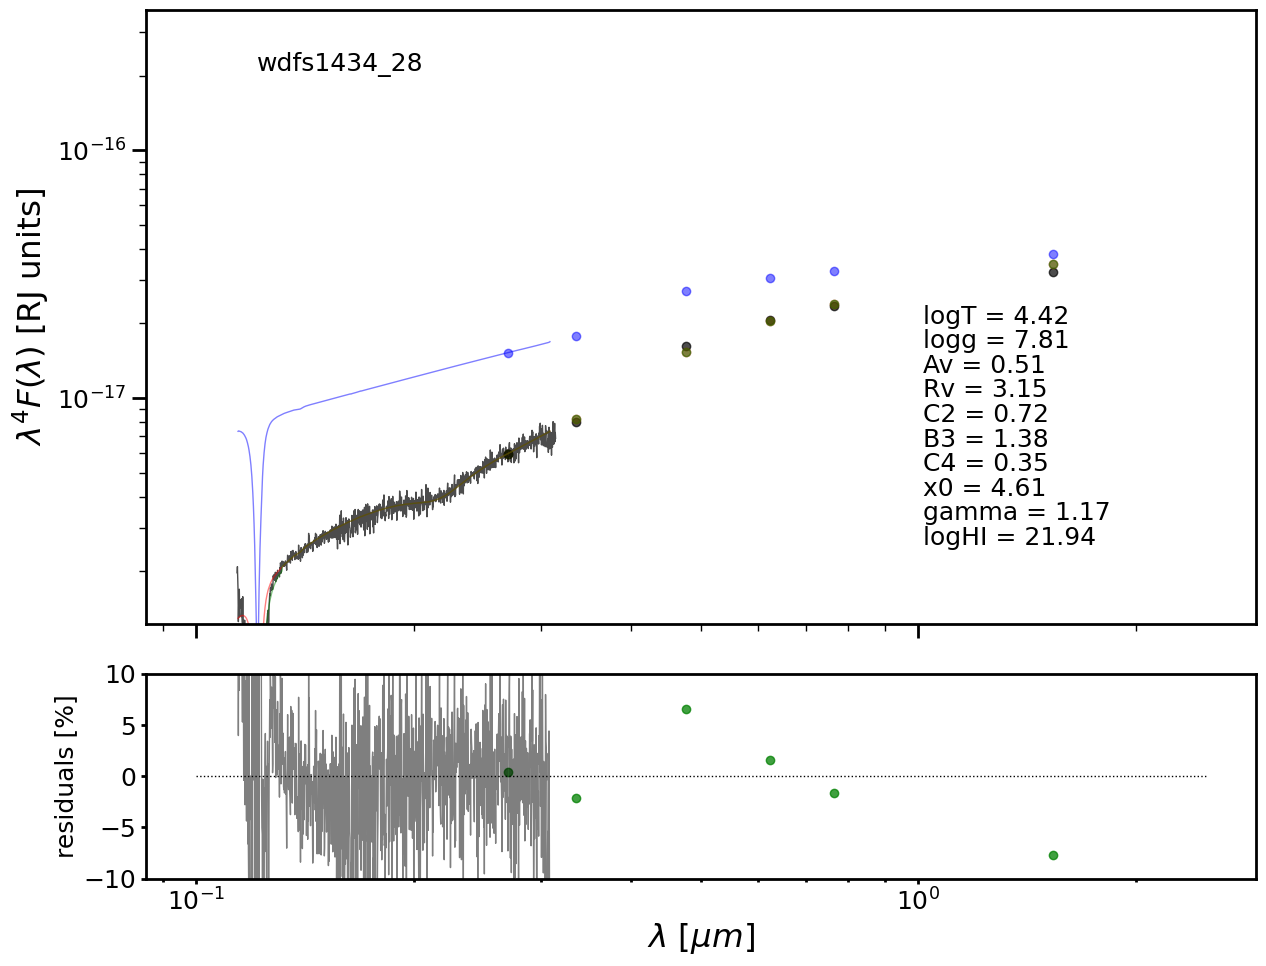

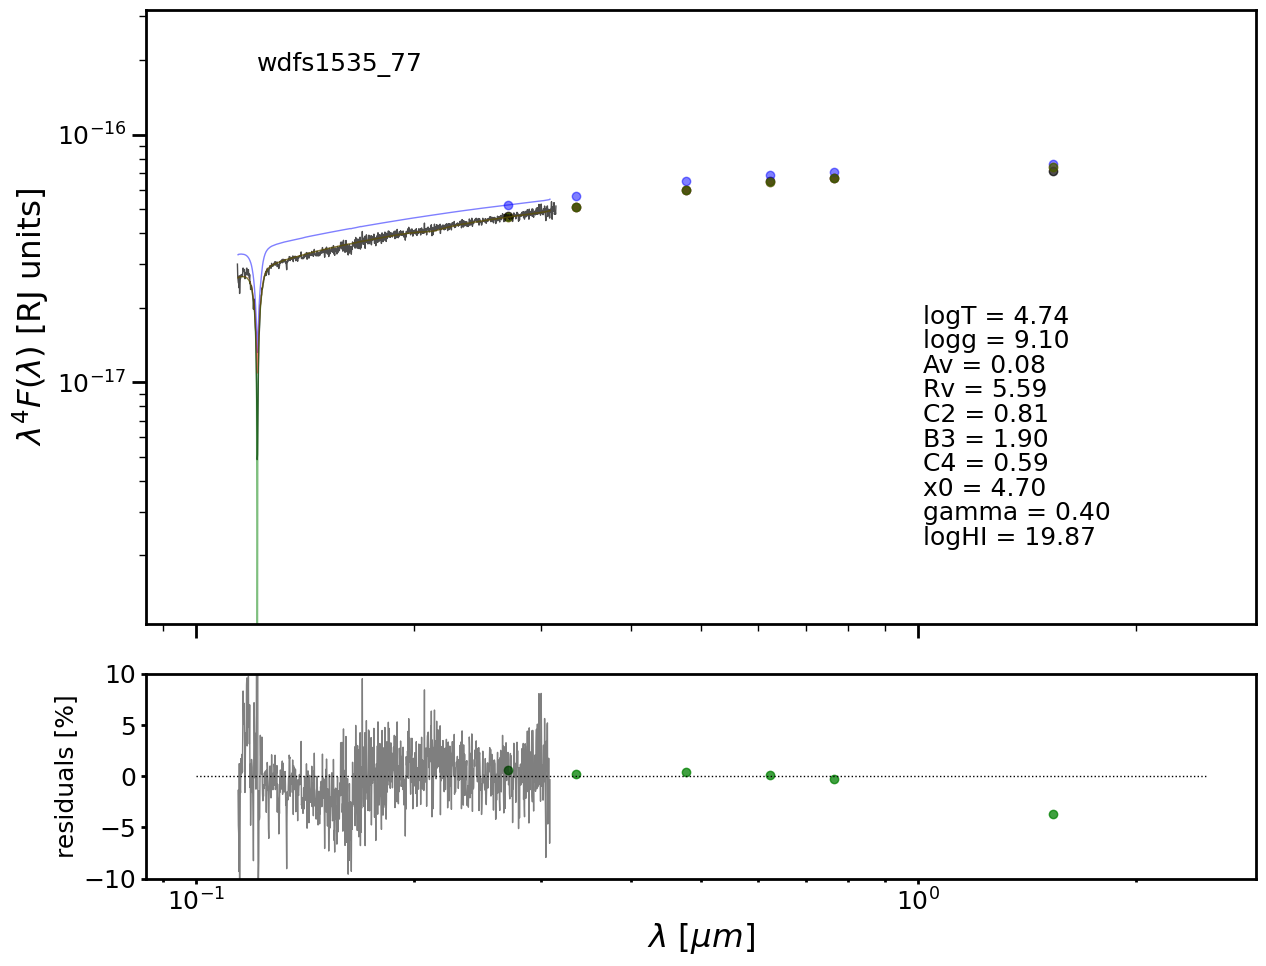

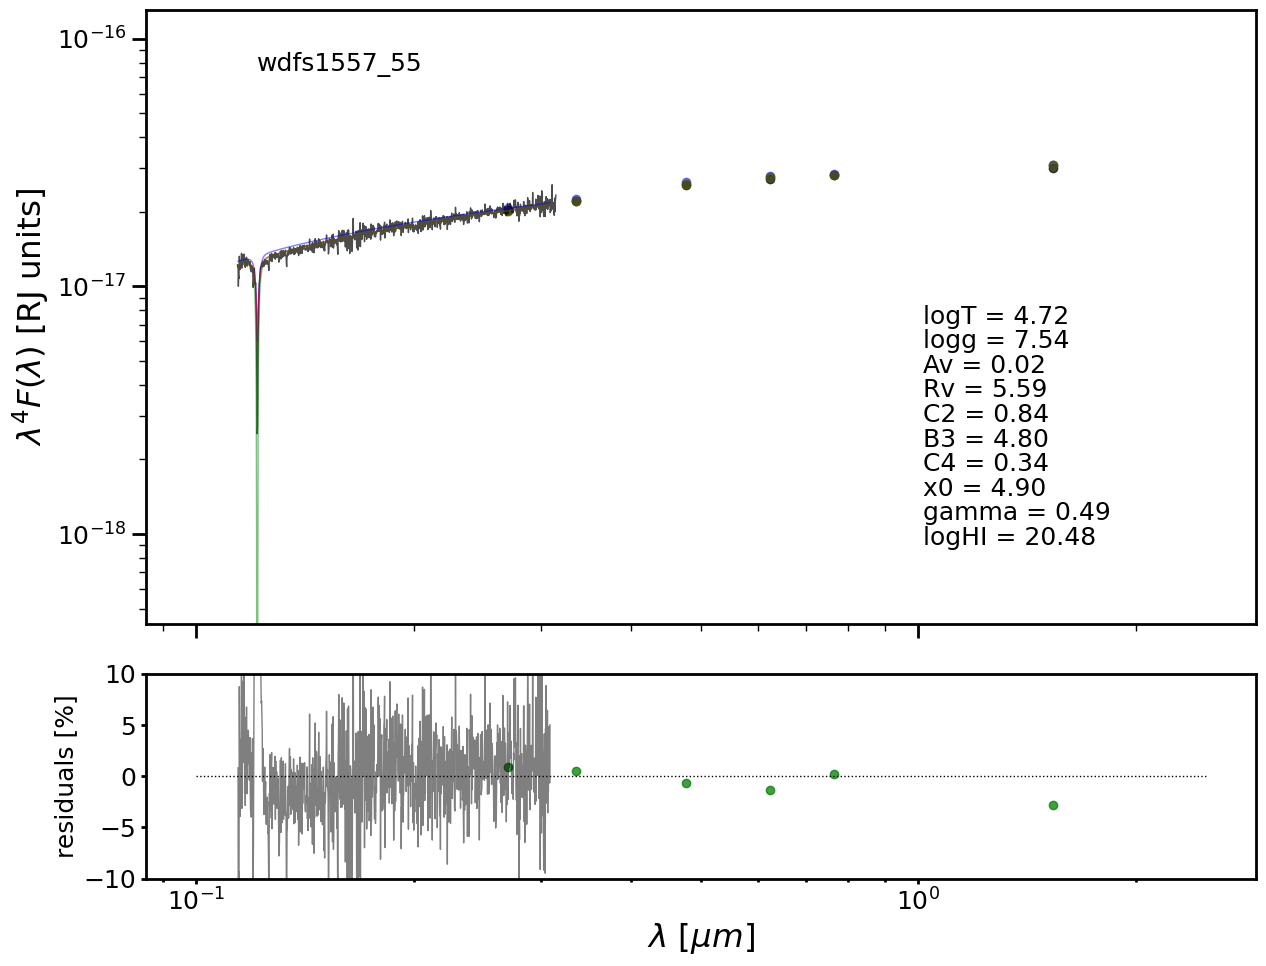

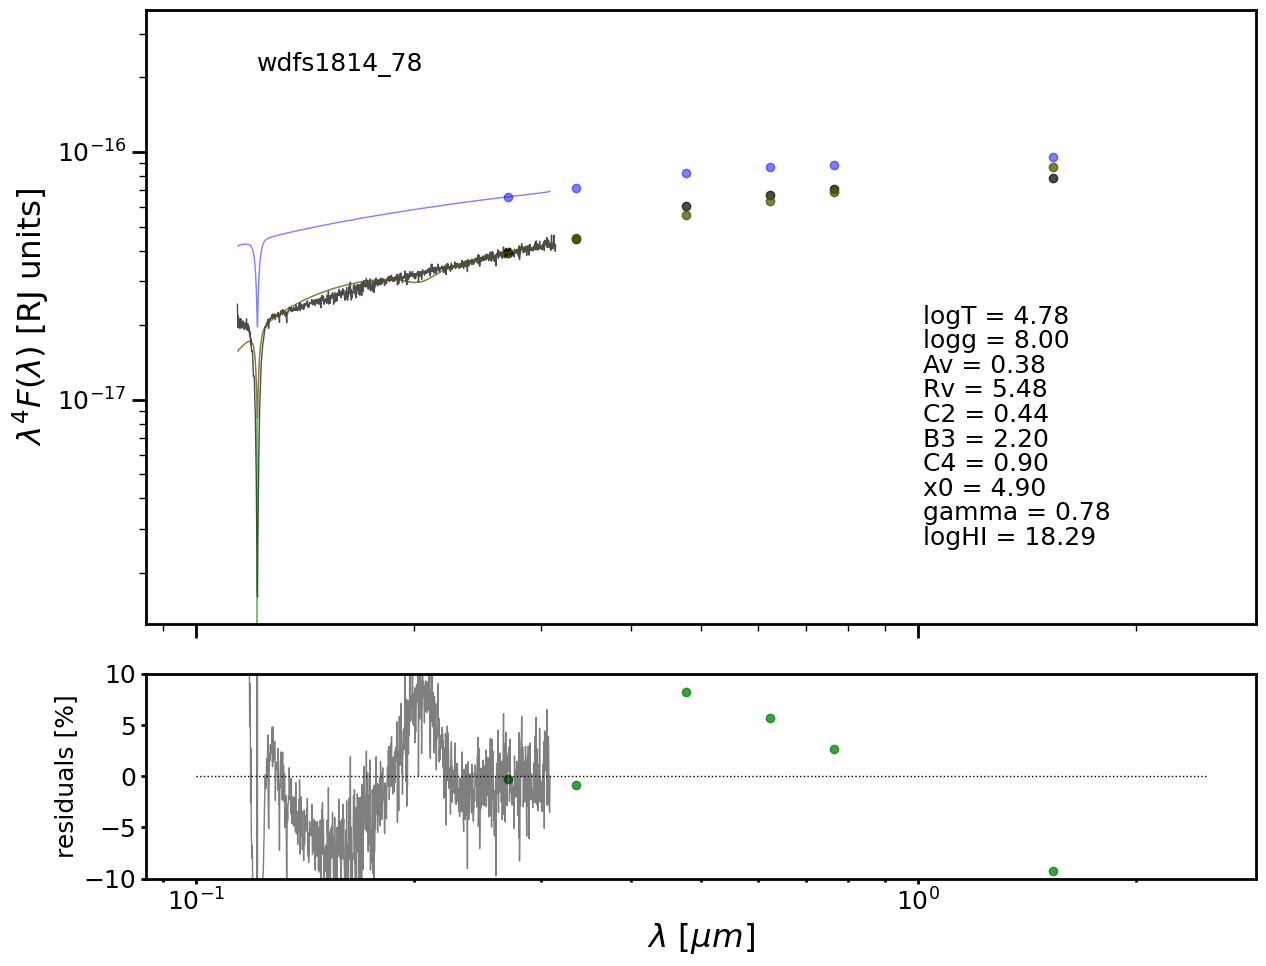

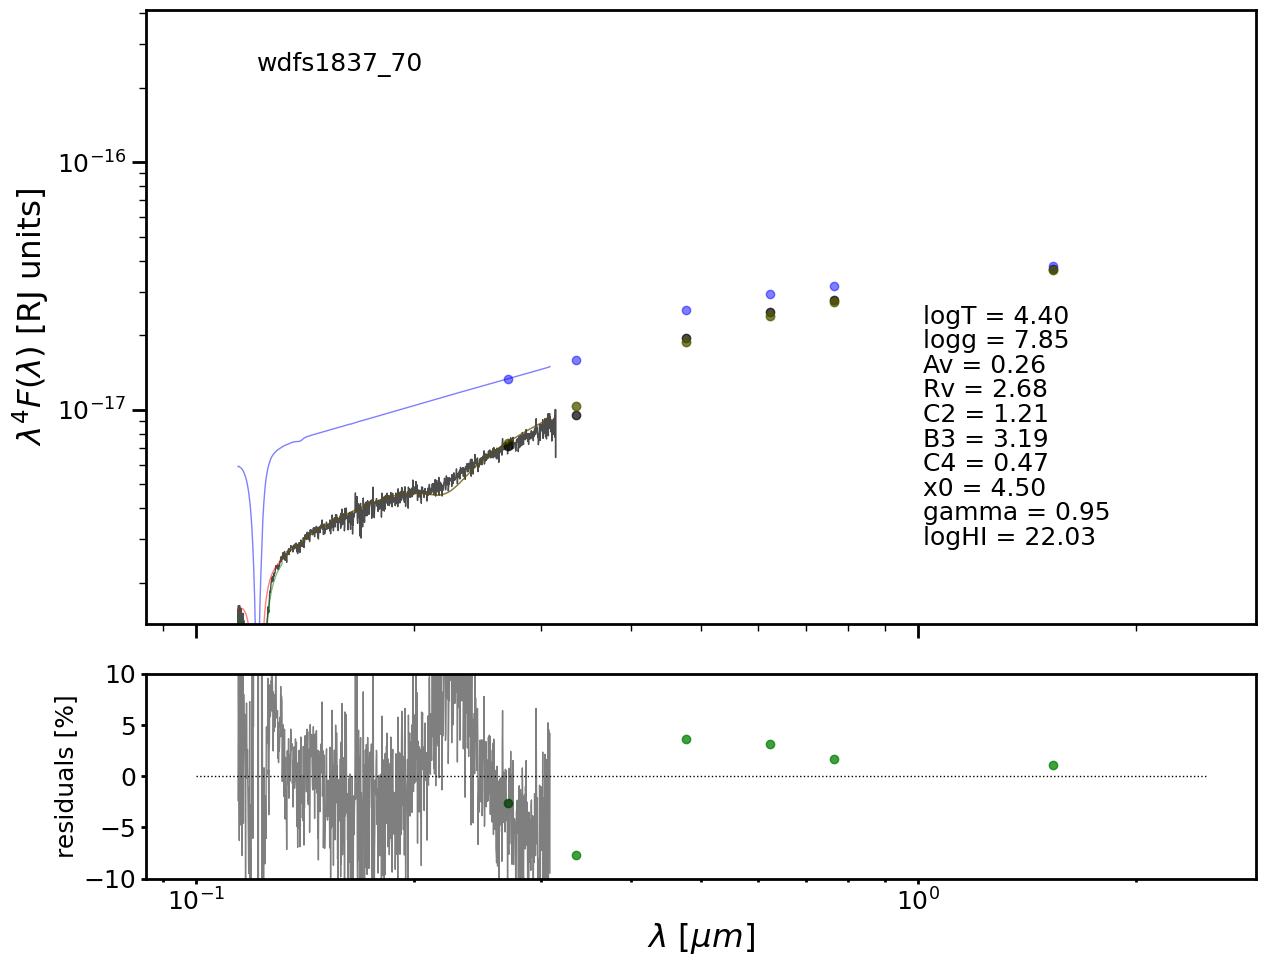

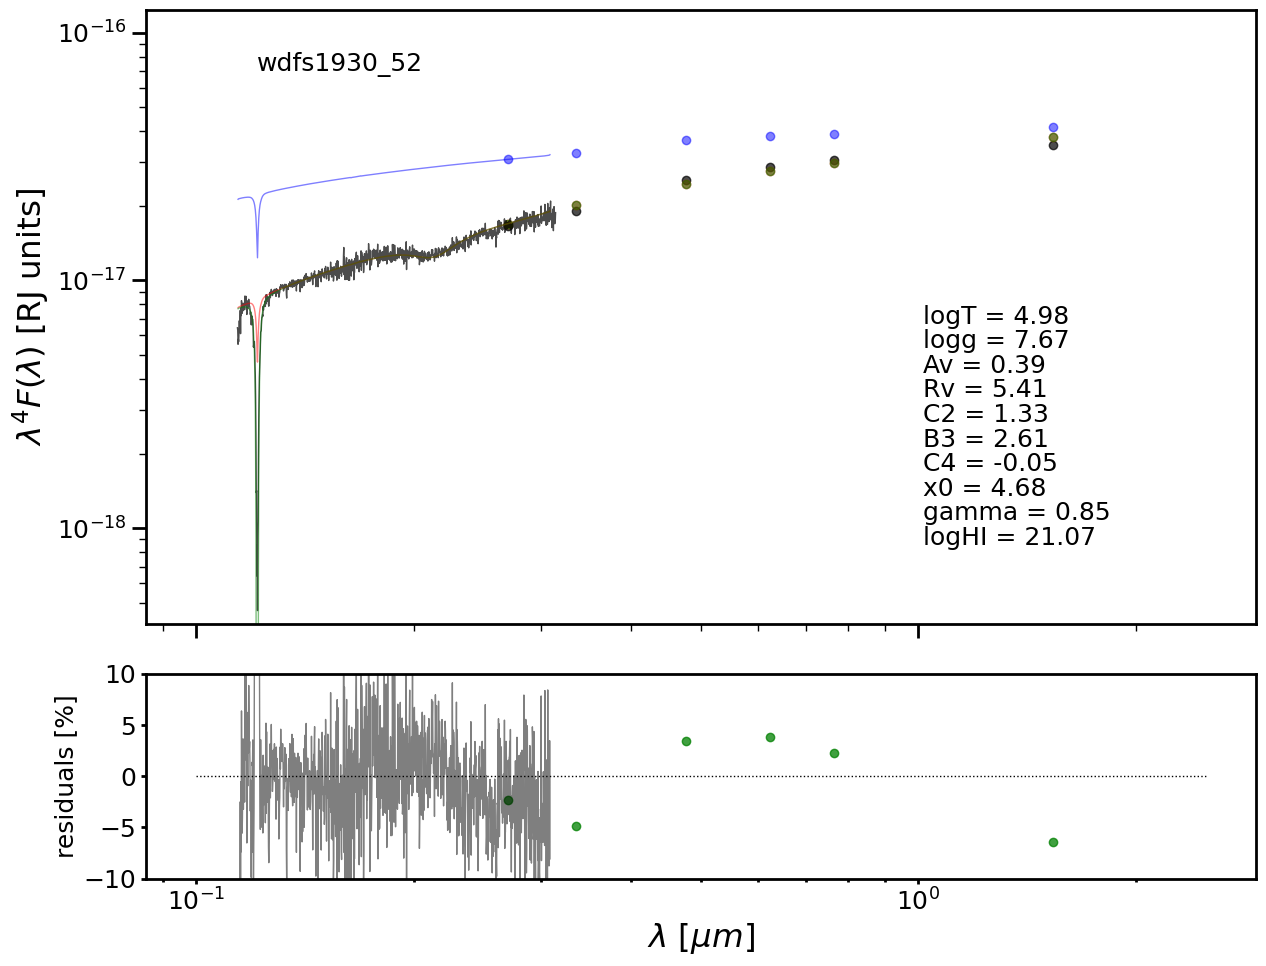

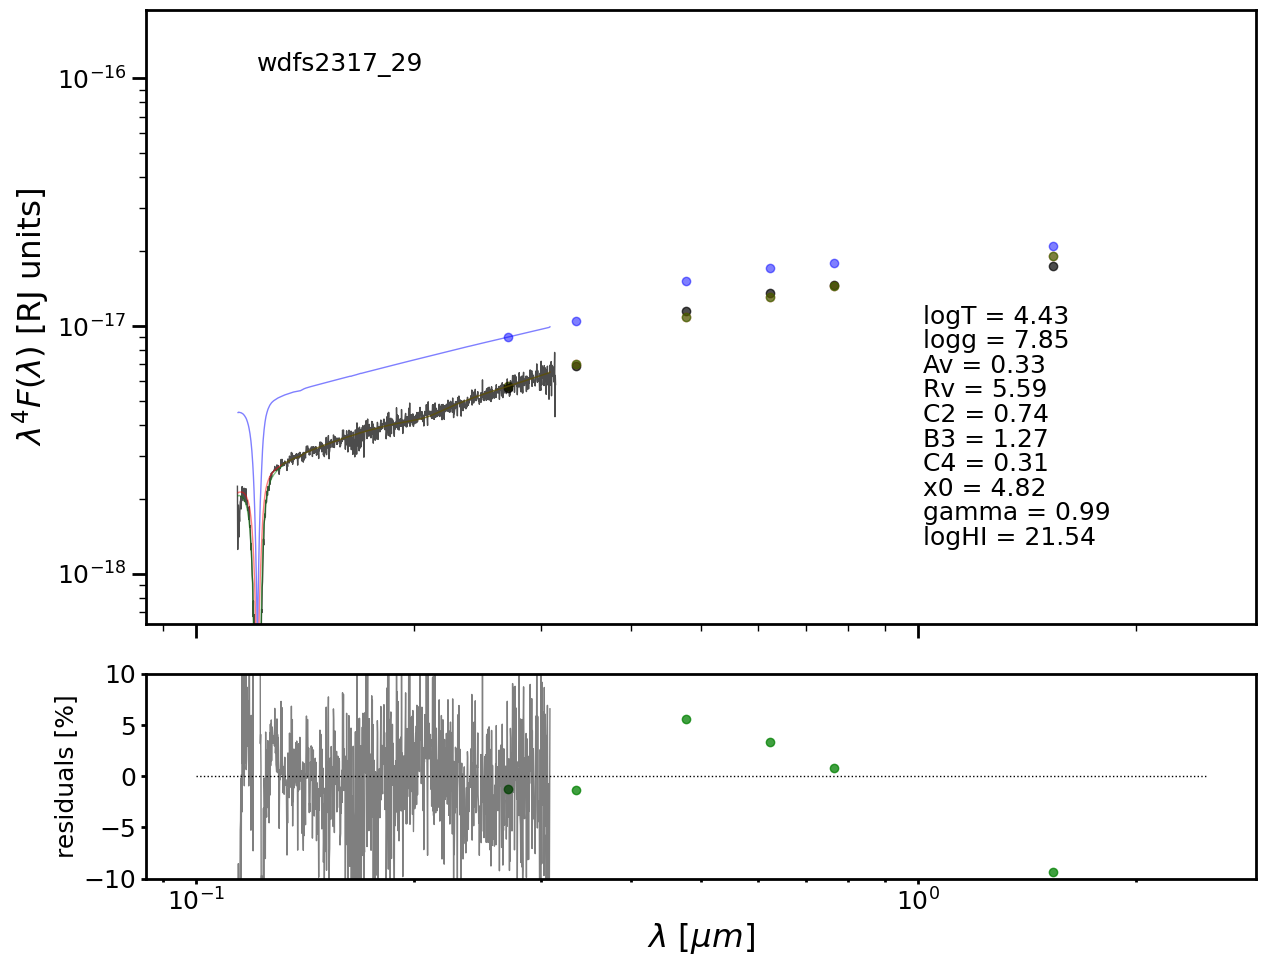

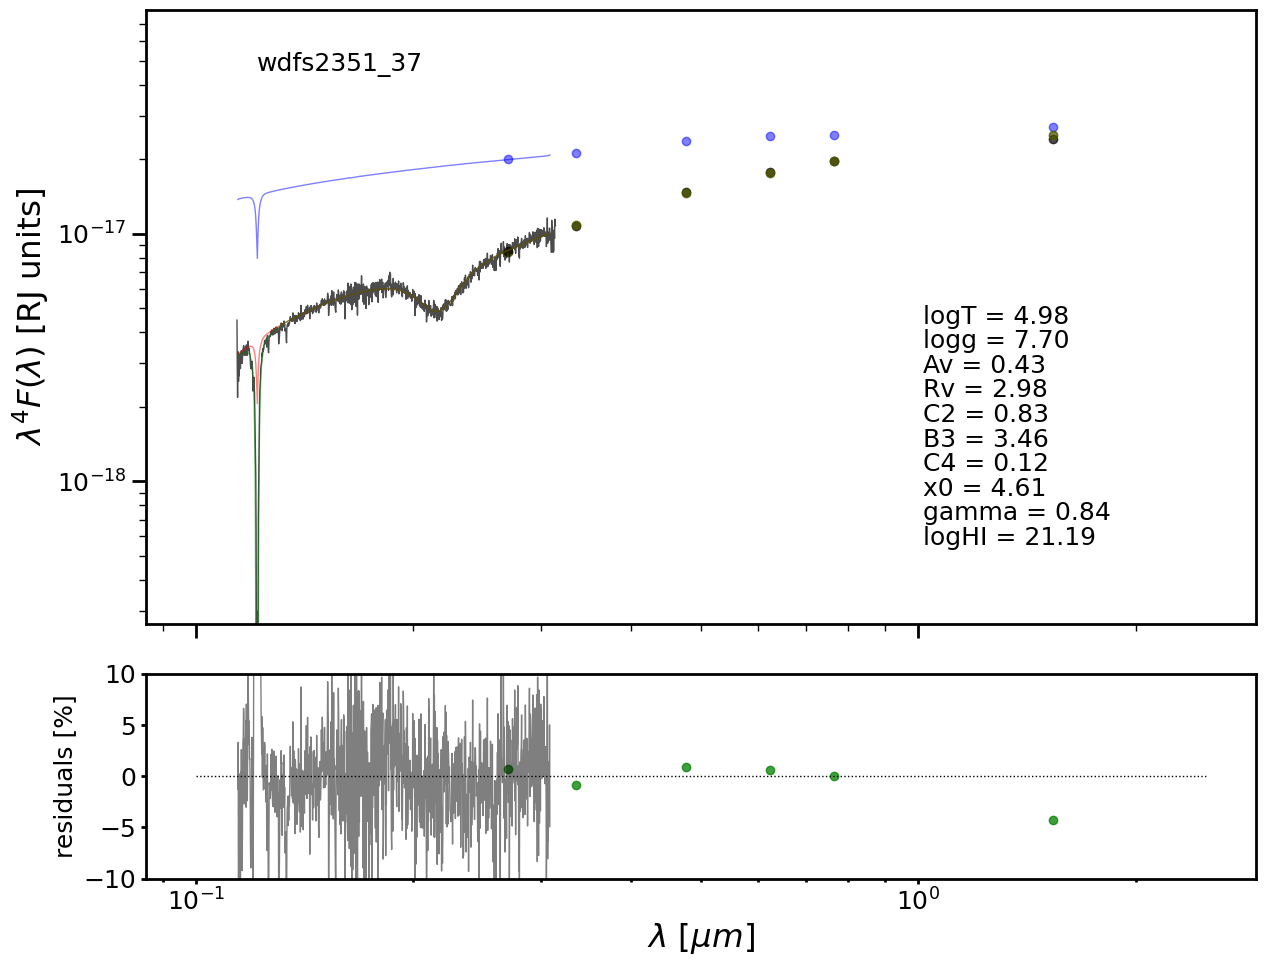

In [10]:
for starname in starnames:
    modinit, modinfo, plimits = fit_star_sed(starname, atmoinfo, velocity,
                                             init_params, pnames, ppriors,
                                             modinit, modinfo, plimits)